# Basic Machine Learning Implementations

1. Sampling
1. Logistic Regression
1. Naive Bayes
1. K Means Clustering
1. Hierarchical Clustering
1. GDA
1. SVM / Kernel Methods

In [125]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import pickle
import seaborn as sns
from sklearn import model_selection

RANDOM_SEED = 42069360

# 1. Sampling

In [126]:
db = pd.read_csv('fifa_final.csv')
db.head()

,Unnamed: 0,id,fifa_year,name,first_name,last_name,ws_team_name,ws_tournament_name,ws_player_id,ws_season,age,height,weight,position,appearances,subs_on,min_played,goal_per_game,assists_total_per_game,yellow_cards_per_game,red_cards_per_game,shots_per_game,aerials_won_per_game,man_of_match_per_game,pass_success,tackles_per_game,interceptions_per_game,fouls_per_game,offsides_won_per_game,clearance_per_game,was_dribbled_per_game,outfielder_blocked_per_game,goal_own_per_game,key_pass_per_game,dribbles_won_per_game,fouls_given_per_game,offsides_given_per_game,dispossessed_per_game,turnovers_per_game,total_passes_per_game,accurate_crosses_per_game,accurate_long_passes_per_game,accurate_through_ball_per_game,fifa_pace,fifa_acceleration,fifa_sprint_speed,fifa_shooting,fifa_positioning,fifa_finishing,fifa_shot_power,fifa_long_shots,fifa_volleys,fifa_penalties,fifa_passing,fifa_vision,fifa_crossing,fifa_free_kick,fifa_short_passing,fifa_long_passing,fifa_curve,fifa_dribbling,fifa_agility,fifa_balance,fifa_reactions,fifa_ball_control,fifa_dribbling_min,fifa_composure,fifa_defense,fifa_marking,fifa_interceptions,fifa_heading_accuracy,fifa_standing_tackle,fifa_sliding_tackle,fifa_physical,fifa_jumping,fifa_stamina,fifa_strength,fifa_aggression,fifa_overall_score,fifa_overall_category
0,0,1,2021,Robert Lewandowski,Robert,Lewandowski,Bayern Munich,Bundesliga,29400,2019/2020,32,184,80,ST,41,0,3649,1.195122,0.219512,0.121951,0.000000,4.825806,2.416129,0.317073,75.885572,0.790323,0.212903,1.066129,0.016129,0.609677,0.593548,0.016129,0,1.630645,1.535484,1.493548,0.474194,1.470968,2.056452,24.770968,0.261290,0.491935,0.114516,78,77,78,91,94,94,89,85,89,88,78,79,71,85,84,70,79,86,77,82,93,88,85,88,43,35,49,85,42,19,82,84,76,86,81,91,gold
1,1,2,2021,Lionel Messi,Lionel,Messi,Barcelona,LaLiga,11119,2019/2020,33,170,72,RW,41,2,3542,0.682927,0.585366,0.146341,0.000000,4.346591,0.339015,0.634146,82.224473,0.443182,0.231061,0.678030,0.000000,0.015152,0.585227,0.000000,0,2.410985,6.320076,2.248106,0.259470,2.369318,1.857955,53.361742,0.596591,2.200758,0.568182,85,91,80,92,93,95,86,94,88,75,91,95,85,94,91,91,93,95,91,95,94,96,96,96,38,32,40,70,35,24,65,68,72,69,44,93,gold
2,2,3,2021,Neymar,Neymar da Silva,Santos Júnior,Paris Saint-Germain,Ligue 1,50835,2019/2020,28,175,68,LW,22,1,1907,0.727273,0.454545,0.227273,0.045455,4.080952,0.176190,0.454545,77.566742,0.900000,0.276190,1.109524,0.000000,0.000000,1.028571,0.000000,0,2.442857,6.071429,4.280952,0.247619,3.104762,4.576190,52.485714,0.685714,1.790476,0.647619,91,94,89,85,87,87,80,84,87,92,86,90,85,89,87,81,88,94,96,83,91,95,95,93,36,35,36,62,30,29,59,62,81,50,51,91,gold
3,3,4,2021,Harry Kane,Harry,Kane,Tottenham,Premier League,83532,2019/2020,27,188,89,ST,34,0,3040,0.705882,0.058824,0.147059,0.000000,3.696552,2.075862,0.176471,71.118574,0.610345,0.103448,1.037931,0.000000,0.917241,0.424138,0.120690,0,0.865517,1.282759,1.458621,0.644828,0.951724,1.872414,19.334483,0.168966,0.996552,0.186207,68,66,69,91,93,94,91,86,85,90,80,83,75,68,81,83,80,81,69,73,90,84,80,91,47,56,35,85,36,38,83,79,84,84,81,88,gold
4,4,5,2021,Toni Kroos,Toni,Kroos,Real Madrid,LaLiga,31772,2019/2020,30,183,76,CM,41,4,3196,0.121951,0.146341,0.073171,0.000000,1.980952,0.254762,0.073171,93.646575,2.050000,1.078571,0.816667,0.014286,0.352381,1.742857,0.000000,0,2.871429,1.011905,1.364286,0.111905,0.602381,0.895238,75.038095,1.402381,7.804762,0.097619,54,57,52,81,76,76,89,86,82,73,91,90,88,84,93,93,86,81,63,71,89,89,80,88,71,72,79,58,73,60,69,32,75,73,60,88,gold


In [127]:
# Feature Set for Predicting Card Level / Color
card_level_db = db[db.min_played >= 90] 
card_level_db = pd.concat([card_level_db.iloc[:, 7:40].drop(columns=['ws_season']), card_level_db.iloc[:, -1]], axis=1)

# Card Labels for Level / Color
card_labels = card_level_db.fifa_overall_category.map({'bronze': 0, 'silver': 1, 'gold': 2})

# Card Features for Level / Color
card_features = card_level_db.drop(columns=['fifa_overall_category'])
card_features = pd.get_dummies(card_features, drop_first=True, columns=['ws_tournament_name', 'position'])

# Splitting training and testing data, hard 80/20 Split
train_card_features, test_card_features, train_card_labels, test_card_labels = model_selection.train_test_split(card_features, card_labels, test_size=0.2, random_state=RANDOM_SEED)

# Card Groups for Level / Color, Training
train_card_groups = train_card_features.ws_player_id
train_card_features = train_card_features.drop(columns=['ws_player_id'])

# Card Groups for Level / Color, Testing
test_card_groups = test_card_features.ws_player_id
test_card_features = test_card_features.drop(columns=['ws_player_id'])

In [128]:
# Pickling the Data
pickle.dump(train_card_features, open('train_card_features.pickle', mode='wb'))
display(train_card_features.describe())

,age,height,weight,appearances,subs_on,min_played,goal_per_game,assists_total_per_game,yellow_cards_per_game,red_cards_per_game,shots_per_game,aerials_won_per_game,man_of_match_per_game,pass_success,tackles_per_game,interceptions_per_game,fouls_per_game,offsides_won_per_game,clearance_per_game,was_dribbled_per_game,outfielder_blocked_per_game,goal_own_per_game,key_pass_per_game,dribbles_won_per_game,fouls_given_per_game,offsides_given_per_game,dispossessed_per_game,turnovers_per_game,total_passes_per_game,ws_tournament_name_Bundesliga,ws_tournament_name_Bundesliga II,ws_tournament_name_Champions League,ws_tournament_name_Eredivisie,ws_tournament_name_Europa League,ws_tournament_name_LaLiga,ws_tournament_name_League One,ws_tournament_name_League Two,ws_tournament_name_Liga NOS,ws_tournament_name_Ligue 1,ws_tournament_name_Major League Soccer,ws_tournament_name_Premier League,ws_tournament_name_Serie A,ws_tournament_name_Super Lig,ws_tournament_name_Super league,ws_tournament_name_Superliga,ws_tournament_name_UEFA Nations League A,position_CB,position_CDM,position_CF,position_CM,position_GK,position_LB,position_LF,position_LM,position_LW,position_LWB,position_RB,position_RF,position_RM,position_RW,position_RWB,position_ST
count,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000,15549.000000
mean,28.304650,181.809827,76.305936,20.830278,3.948228,1512.860441,0.084559,0.060634,0.140497,0.008134,0.818170,1.179992,0.031467,76.230561,1.210830,0.900366,0.933831,0.147143,1.503382,0.621746,0.212004,0.000064,0.611780,0.605459,0.850988,0.128276,0.701410,1.001887,30.021176,0.084121,0.051386,0.010997,0.064377,0.042575,0.096855,0.002894,0.009968,0.063412,0.086951,0.086629,0.100650,0.091774,0.070873,0.044955,0.080455,0.001093,0.184642,0.088945,0.007010,0.115892,0.084314,0.079298,0.000064,0.057882,0.023731,0.003730,0.081356,0.000064,0.059875,0.020194,0.003537,0.134221
std,4.326582,6.650296,7.016050,11.133984,4.476860,981.922290,0.131003,0.083150,0.123170,0.026422,0.747191,1.082731,0.055504,9.865642,0.842376,0.768591,0.574338,0.259036,1.574990,0.468875,0.271796,0.008020,0.550288,0.612937,0.621470,0.221581,0.616962,0.773844,14.317383,0.277578,0.220791,0.104294,0.245431,0.201904,0.295770,0.053720,0.099347,0.243711,0.281772,0.281300,0.300874,0.288716,0.256620,0.207211,0.272006,0.033048,0.388019,0.284673,0.083435,0.320105,0.277867,0.270212,0.008020,0.233527,0.152216,0.060963,0.273389,0.008020,0.237263,0.140669,0.059371,0.340900
min,17.000000,156.000000,55.000000,1.000000,0.000000,90.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.814815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.187500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,177.000000,71.000000,11.000000,0.000000,643.000000,0.000000,0.000000,0.047619,0.000000,0.277778,0.400000,0.000000,71.428571,0.583333,0.250000,0.548246,0.000000,0.363636,0.280000,0.000000,0.000000,0.196429,0.166667,0.400000,0.00

# 2. Dataset Features

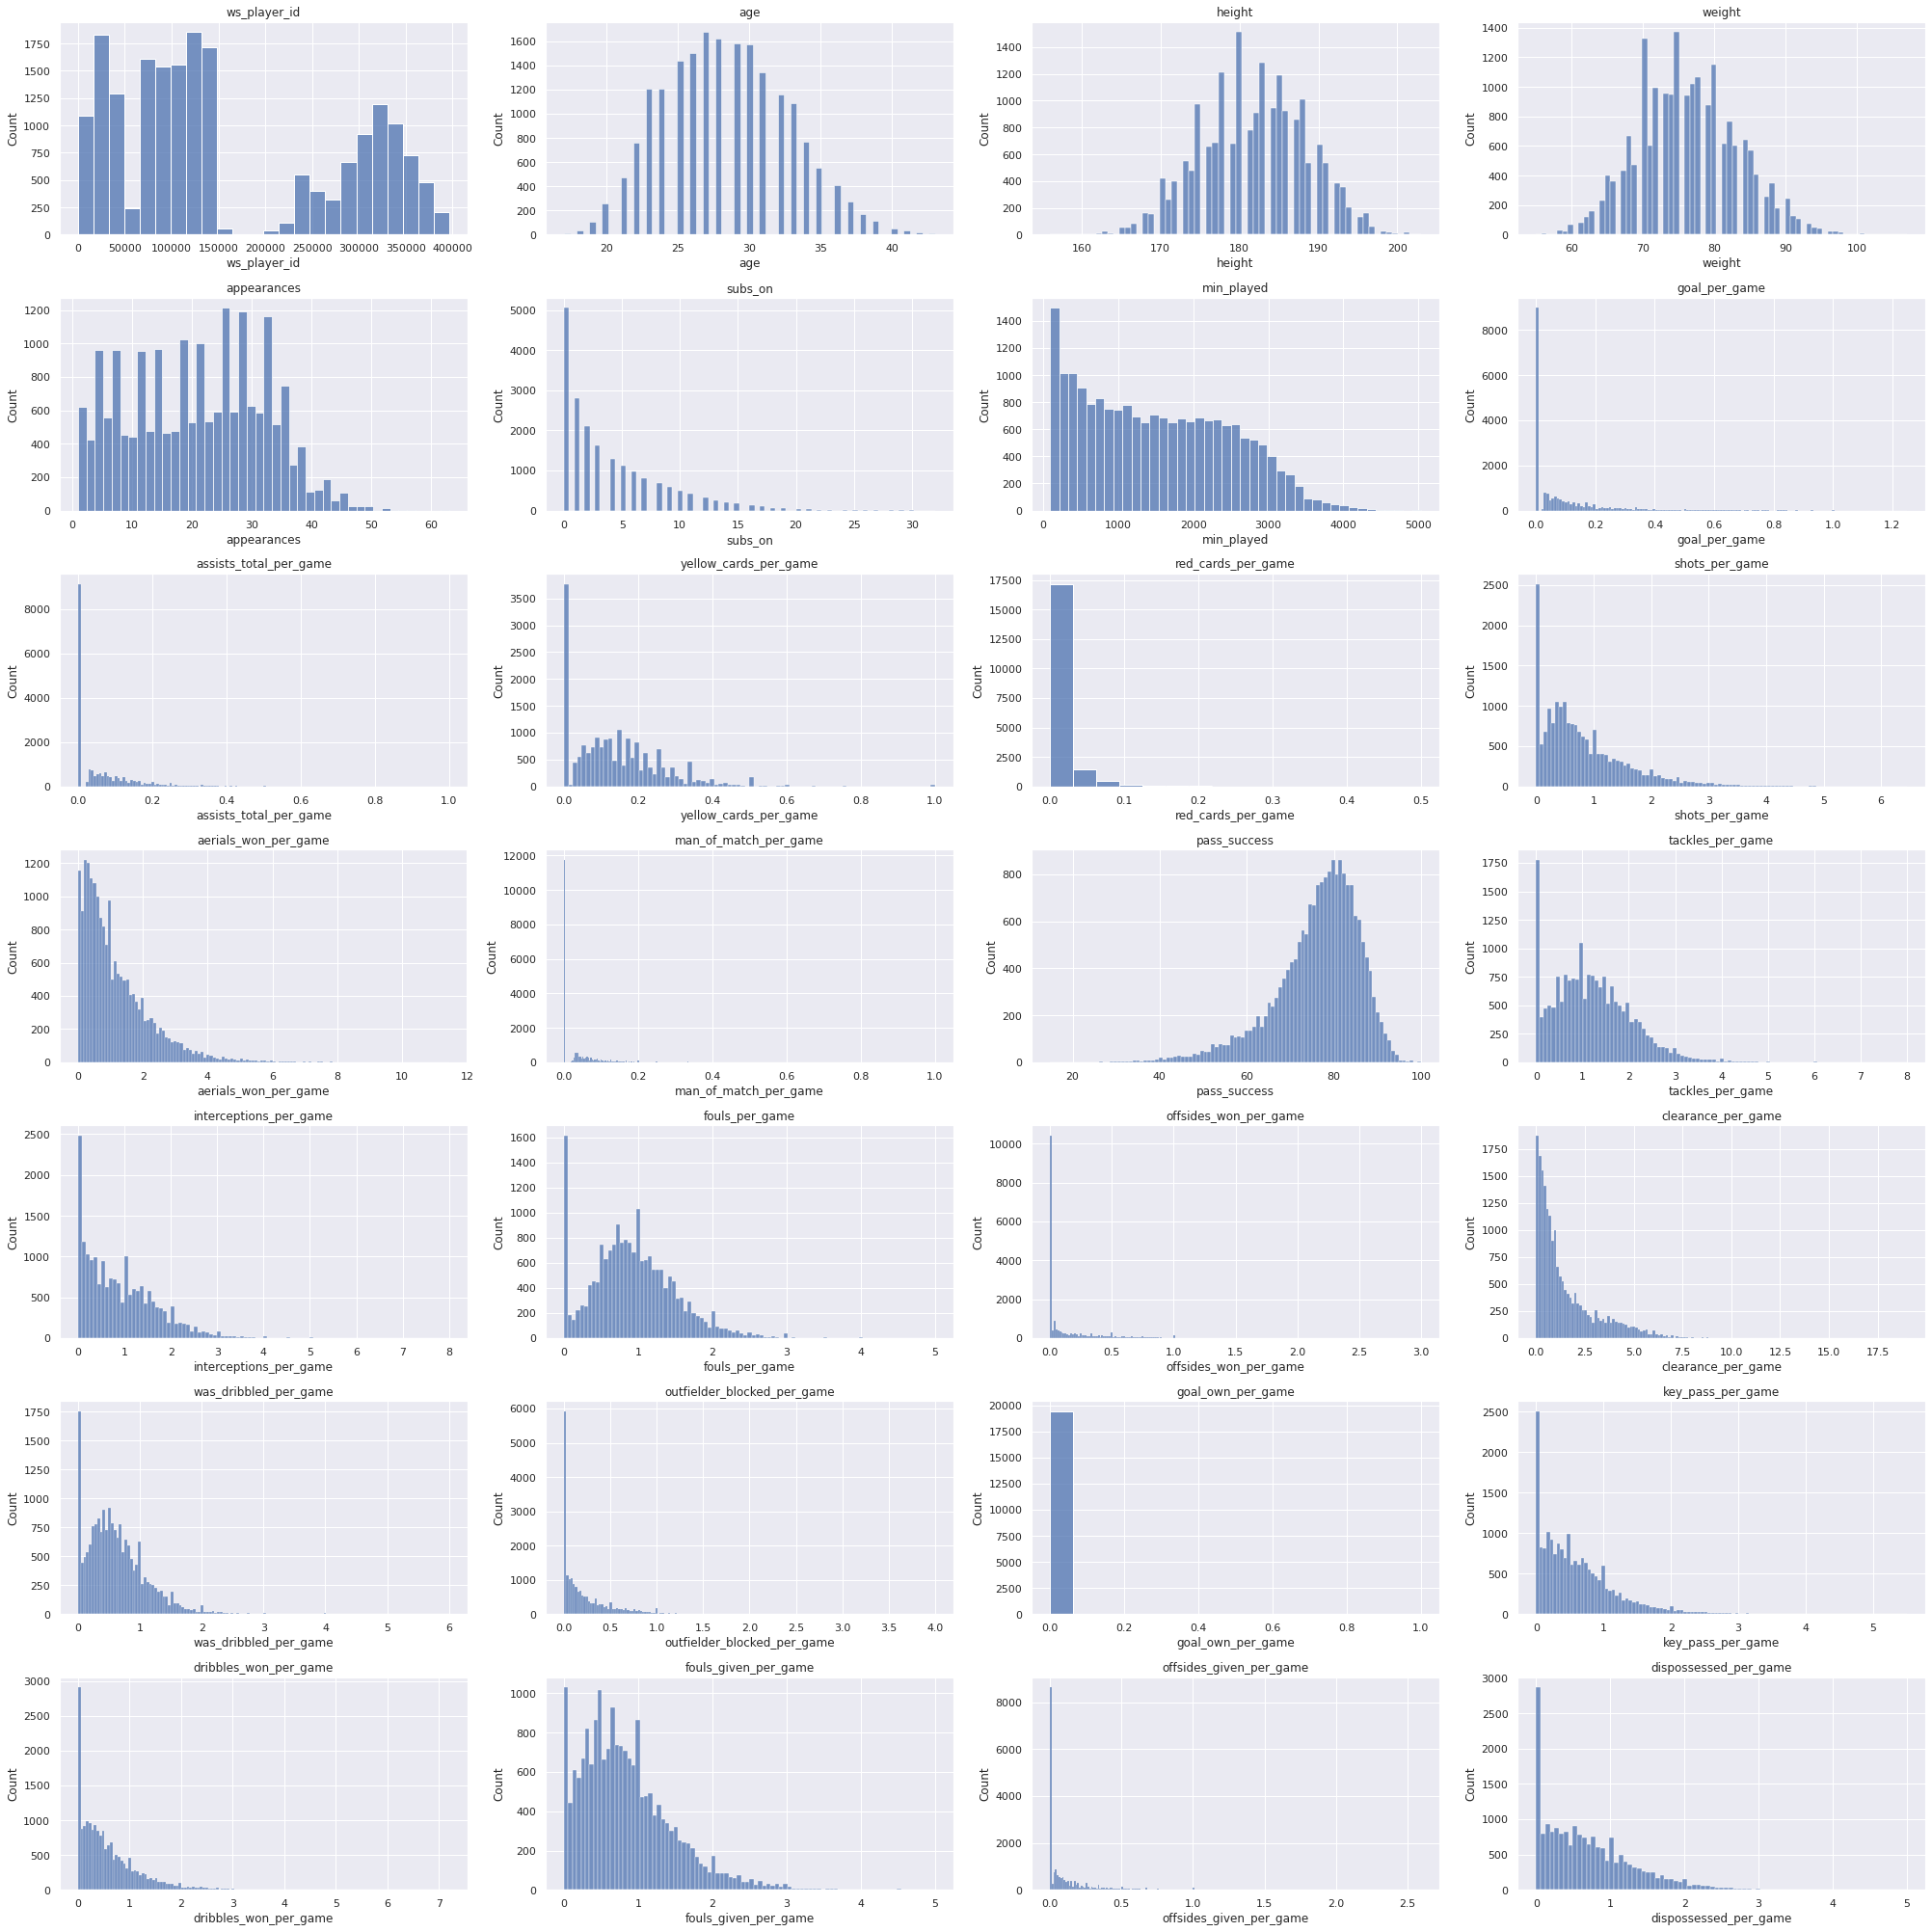

In [ ]:
# Graphing Data Points
sns.set_theme("notebook")

num_features = 28
fig, ax = plt.subplots(7, 4, figsize=(28,28))
iter = 0
for i in range(7):
  for j in range(4):
    sns.histplot(card_features.iloc[:, iter], ax = ax[i, j])
    ax[i,j].set_title(card_features.columns.to_list()[iter])
    iter += 1
fig.tight_layout()


# 3. Model Benchmarking

In [130]:
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import dummy
from sklearn import tree
from sklearn import neighbors
from sklearn import discriminant_analysis
from sklearn import svm
from sklearn import preprocessing

In [131]:
class ModelValidator():
  fig_size = (5,4)

  pred_func_dict = {
      'Dummy': 'proba',
      'GaussianNB': 'proba',
      'LogisticRegression': 'proba',
      'DecisionTree': 'proba',
      'KNN': 'proba',
      'LDA': 'proba',
      'Ridge': 'deci',
      'SVM-SVC': 'deci',
      'LinearSVC': 'deci'
  }

  reg_strategy = {
      'minmax': set(),
      'normalize': set(),
      'none': set(),
  }

  def __init__(self, features, labels, groups):
    self.X = features.copy()  # Features
    self.Y = labels.copy()  # Labels
    self.groups = groups.copy()  # PlayerId DataSeries

    self.Xminmax = pd.DataFrame(np.concatenate([preprocessing.minmax_scale(features.iloc[:,:29]), features.iloc[:,30:]], axis=1))
    self.Xnorm = pd.DataFrame(np.concatenate([preprocessing.normalize(features.iloc[:,:29]), features.iloc[:,30:]], axis=1))
  
  def model_stats(self, name, clf, target_type):
    kf = model_selection.GroupKFold(n_splits=5)
    all_yts = None
    all_y_pred = None
    all_y_prob = None

    # Function to extract probability
    prob_func = ModelValidator.pred_func_dict[name]

    # Choose regularization strategy for data
    if name in ModelValidator.reg_strategy['minmax']:
      X = self.Xminmax
    elif name in ModelValidator.reg_strategy['normalize']:
      X = self.Xnorm
    else:
      X = self.X
    Y = self.Y
    groups = self.groups

    for train, test in kf.split(X, Y, groups=groups):
      clf.fit(X.iloc[train], Y.iloc[train])
      y_pred = clf.predict(X.iloc[test])

      if prob_func == "proba":
        y_prob = clf.predict_proba(X.iloc[test])
      else:
        y_prob = clf.decision_function(X.iloc[test])

      if all_yts is None or all_y_pred is None:
        all_yts = self.Y.iloc[test]
        all_y_pred = pd.Series(y_pred)
        all_y_prob = pd.DataFrame(y_prob)
      else:
        all_yts = pd.concat([all_yts, Y.iloc[test]])
        all_y_pred = pd.concat([all_y_pred, pd.Series(y_pred)])
        all_y_prob = pd.concat([all_y_prob, pd.DataFrame(y_prob)])
    
    if name == 'Ridge' or name == 'LinearSVC':
      all_y_prob = np.exp(all_y_prob) / np.sum(np.exp(all_y_prob), axis=1)[:,None]

    if target_type == 'color':
      target_names = ['bronze', 'silver', 'gold']

    print(f"{name} Model Report (Avg):")
    print(metrics.classification_report(all_yts, all_y_pred, target_names=target_names))
    print(f"Balanced Accuracy: {metrics.balanced_accuracy_score(all_yts, all_y_pred)}")
    print(f"ROC AUC Values: {metrics.roc_auc_score(all_yts, all_y_prob, multi_class='ovr', average='weighted')}")
    
    plt.figure(figsize=ModelValidator.fig_size)
    for i in range(len(target_names)):
      fp, tp, thr = metrics.roc_curve(all_yts, all_y_prob.iloc[:,i], pos_label=i)
      sns.lineplot(x=fp, y=tp, ci=None, estimator=None, label=target_names[i])
    plt.legend()
    plt.title('ROC Curve')
    plt.ylabel('TP Rate')
    plt.xlabel('FP Rate')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=ModelValidator.fig_size)
    for i in range(len(target_names)):
      pr, rc, thr = metrics.precision_recall_curve(all_yts, all_y_prob.iloc[:,i], pos_label=i)
      sns.lineplot(x=rc, y=pr, ci=None, estimator=None, label=target_names[i])
    plt.legend()
    plt.title('Precision Recall Curve')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=ModelValidator.fig_size)
    confusion_matrix = metrics.confusion_matrix(all_yts, all_y_pred, normalize='all')
    sns.heatmap(confusion_matrix, annot=True).set_title('Confusion Matrix')
    plt.tight_layout()
    plt.show()
  
  def player_color_rank(self, to_run=None):

    if to_run is None or "gnb" in to_run:
      gauss_nb = naive_bayes.GaussianNB()
      # self.model_stats("GaussianNB", gauss_nb, "color")
      gauss_nb.fit(self.X, self.Y)
      yp = gauss_nb.predict(test_card_features)
      print("GAUSS")
      print(metrics.classification_report(test_card_labels, yp, target_names=['bronze', 'silver', 'gold']))
      print(metrics.balanced_accuracy_score(test_card_labels, yp))
      plt.figure(figsize=ModelValidator.fig_size)
      confusion_matrix = metrics.confusion_matrix(test_card_labels, yp, normalize='all')
      sns.heatmap(confusion_matrix, annot=True).set_title('Gauss Confusion Matrix')
      plt.tight_layout()
      plt.show()
      # models.append("Gaussian Naïve Bayes")

    if to_run is None or "logreg" in to_run:
      logreg = linear_model.LogisticRegression(solver="newton-cg", class_weight="balanced", multi_class='ovr', n_jobs=-1, max_iter=10000)
      # self.model_stats("LogisticRegression", logreg, "color")
      logreg.fit(self.X, self.Y)
      yp = logreg.predict(test_card_features)
      print("LOGREG")
      print(metrics.classification_report(test_card_labels, yp, target_names=['bronze', 'silver', 'gold']))
      print(metrics.balanced_accuracy_score(test_card_labels, yp))
      plt.figure(figsize=ModelValidator.fig_size)
      confusion_matrix = metrics.confusion_matrix(test_card_labels, yp, normalize='all')
      sns.heatmap(confusion_matrix, annot=True).set_title('Logreg Confusion Matrix')
      plt.tight_layout()
      plt.show()
      # models.append("Logistic Regression")    

    if to_run is None or "dectree" in to_run:
      dectree = tree.DecisionTreeClassifier()
      self.model_stats("DecisionTree", dectree, "color")
      
      models.append("Decision Tree")

    if to_run is None or "knn" in to_run:
      knn = KNeighborsClassifier(n_neighbors=3, weights='distance')
      self.model_stats("KNN", knn, "color")
      
      models.append("K Nearest Neighbors")

    if to_run is None or "lda" in to_run:
      lda = discriminant_analysis.LinearDiscriminantAnalysis()
      # self.model_stats("LDA", lda, "color")
      lda.fit(self.X, self.Y)
      yp = lda.predict(test_card_features)
      print("LDA w/ SMOTE")
      print(metrics.classification_report(test_card_labels, yp, target_names=['bronze', 'silver', 'gold']))
      print(metrics.balanced_accuracy_score(test_card_labels, yp))
      plt.figure(figsize=ModelValidator.fig_size)
      confusion_matrix = metrics.confusion_matrix(test_card_labels, yp, normalize='all')
      sns.heatmap(confusion_matrix, annot=True).set_title('LDA Confusion Matrix')
      plt.tight_layout()
      plt.show()
      # models.append("LDA")

# Running Raw Data

GAUSS
              precision    recall  f1-score   support

      bronze       0.38      0.71      0.49       362
      silver       0.78      0.49      0.60      2129
        gold       0.61      0.82      0.70      1397

    accuracy                           0.63      3888
   macro avg       0.59      0.67      0.60      3888
weighted avg       0.68      0.63      0.63      3888

0.6742641844906848


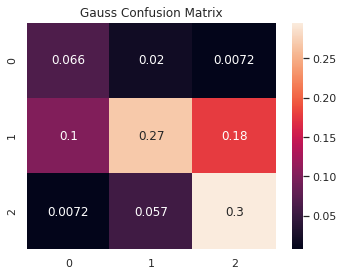

LOGREG
              precision    recall  f1-score   support

      bronze       0.48      0.69      0.56       362
      silver       0.81      0.67      0.73      2129
        gold       0.72      0.82      0.77      1397

    accuracy                           0.73      3888
   macro avg       0.67      0.73      0.69      3888
weighted avg       0.75      0.73      0.73      3888

0.7278995105342131


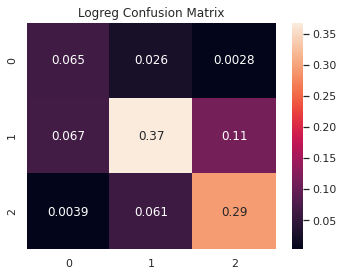

LDA w/ SMOTE
              precision    recall  f1-score   support

      bronze       0.63      0.39      0.48       362
      silver       0.75      0.84      0.79      2129
        gold       0.79      0.73      0.76      1397

    accuracy                           0.76      3888
   macro avg       0.73      0.65      0.68      3888
weighted avg       0.76      0.76      0.75      3888

0.6519821233994741


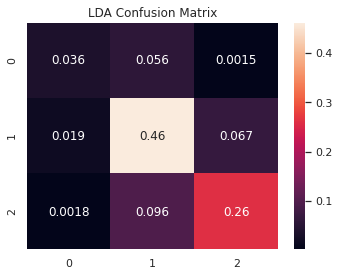

In [133]:
chungus = ModelValidator(train_card_features, train_card_labels, train_card_groups)
chungus.player_color_rank(to_run=["lda", "gnb", "logreg"])

# Random Sampling
SMOTE, 
Undersampling, and Oversampling

```
BEST: Log reg
solver=newton-cg, class_weight="balanced"
LogisticRegression Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.44      0.82      0.57      1498
      silver       0.81      0.64      0.71      8359
        gold       0.74      0.81      0.77      5692

    accuracy                           0.72     15549
   macro avg       0.66      0.75      0.69     15549
weighted avg       0.75      0.72      0.72     15549

Balanced Accuracy: 0.7549663874303872
ROC AUC Values: 0.8671695479291525
```
```
BEST LDA
Default LDA (svg)
LDA Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.65      0.41      0.50      1498
      silver       0.75      0.84      0.79      8359
        gold       0.80      0.73      0.76      5692

    accuracy                           0.76     15549
   macro avg       0.73      0.66      0.69     15549
weighted avg       0.76      0.76      0.75     15549

Balanced Accuracy: 0.6618250307506625
ROC AUC Values: 0.8628703805626633
```
```
LDA (lsqr)
LDA Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.65      0.41      0.50      1498
      silver       0.75      0.84      0.79      8359
        gold       0.80      0.73      0.76      5692

    accuracy                           0.76     15549
   macro avg       0.73      0.66      0.69     15549
weighted avg       0.76      0.76      0.75     15549

Balanced Accuracy: 0.6617851535723717
ROC AUC Values: 0.8628715282261583
```
```
LDA with lsqr and shrinkage auto
LDA Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.64      0.42      0.51      1498
      silver       0.75      0.84      0.79      8359
        gold       0.80      0.73      0.76      5692

    accuracy                           0.76     15549
   macro avg       0.73      0.66      0.69     15549
weighted avg       0.76      0.76      0.75     15549

Balanced Accuracy: 0.6627270009577078
ROC AUC Values: 0.8634265186578682
```

In [ ]:
# IMPORTS
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
"""
SMOTE Function:
"""
def get_smote_resample(train_card_features, train_card_labels, train_card_groups, samp_strat='auto'):
  X_super = pd.concat([train_card_features, train_card_groups], 1)
  # Resample the training dataset
  oversample = SMOTE(random_state=RANDOM_SEED, sampling_strategy=samp_strat)
  X, y = oversample.fit_resample(X_super, train_card_labels) 
  X_groups = X[:,-1]
  X = X[:,:-1]
  X, y, X_groups = pd.DataFrame(X), pd.DataFrame(y), pd.DataFrame(X_groups)
  """
  Convet the decimal clasifications to a binary calssification. 
  
  """
  return X, y, X_groups

"""
Under Sample:
"""
def get_undersample(train_card_features, train_card_labels, train_card_groups, samp_strat='auto'):
  X_super = pd.concat([train_card_features, train_card_groups], 1)
  # Resample the training set
  rus = RandomUnderSampler(random_state=RANDOM_SEED, sampling_strategy=samp_strat)
  X, y = rus.fit_resample(X_super, train_card_labels)
  X_groups = X[:,-1]
  X = X[:,:-1]
    X = X[:,:-1]
  X, y, X_groups = pd.DataFrame(X), pd.DataFrame(y), pd.DataFrame(X_groups)
  return X, y, X_groups

"""
Over Sample:
"""
def get_oversample(train_card_features, train_card_labels, train_card_groups, samp_strat='auto'):
  X_super = pd.concat([train_card_features, train_card_groups], 1)
  # Resample the training set
  ros = RandomOverSampler(random_state=RANDOM_SEED, sampling_strategy=samp_strat)
  X, y = ros.fit_resample(X_super, train_card_labels)
  X_groups = X[:,-1]
  X = X[:,:-1]
  X, y, X_groups = pd.DataFrame(X), pd.DataFrame(y), pd.DataFrame(X_groups)
  return X, y, X_groups

# Raw SMOTE Oversample (to silver)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Dummy Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.32      0.32      0.32      8359
      silver       0.34      0.34      0.34      8359
        gold       0.34      0.33      0.34      8359

    accuracy                           0.33     25077
   macro avg       0.33      0.33      0.33     25077
weighted avg       0.33      0.33      0.33     25077

Balanced Accuracy: 0.33054193085297284
ROC AUC Values: 0.5024823543486063


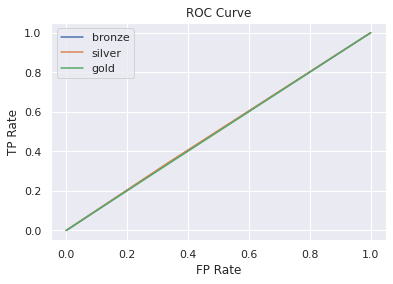

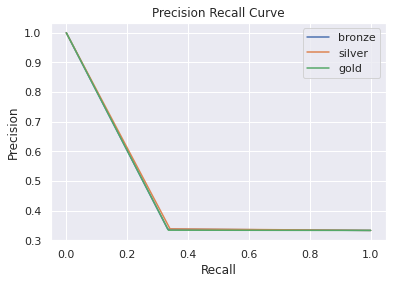

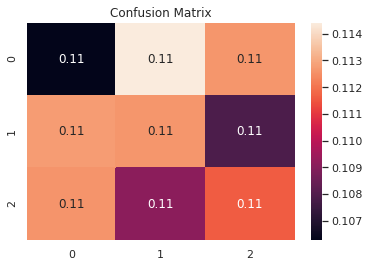

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

GaussianNB Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.76      0.85      0.80      8359
      silver       0.66      0.41      0.51      8359
        gold       0.68      0.84      0.75      8359

    accuracy                           0.70     25077
   macro avg       0.70      0.70      0.69     25077
weighted avg       0.70      0.70      0.69     25077

Balanced Accuracy: 0.7015990748494637
ROC AUC Values: 0.8717845029652252


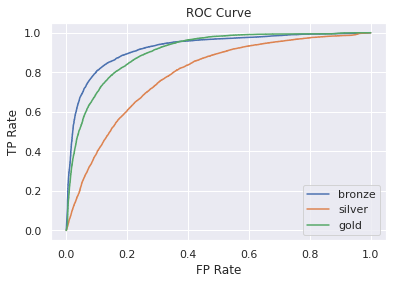

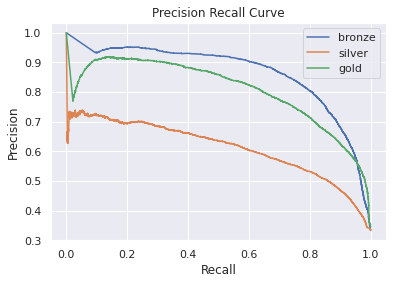

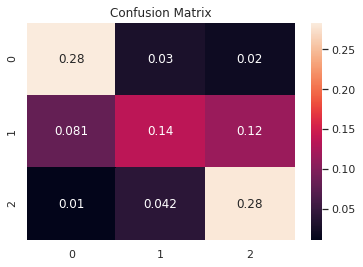

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

LogisticRegression Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.62      0.70      0.66      8359
      silver       0.44      0.33      0.38      8359
        gold       0.63      0.70      0.66      8359

    accuracy                           0.58     25077
   macro avg       0.56      0.58      0.57     25077
weighted avg       0.56      0.58      0.57     25077

Balanced Accuracy: 0.5776209275431671
ROC AUC Values: 0.7670855330362958


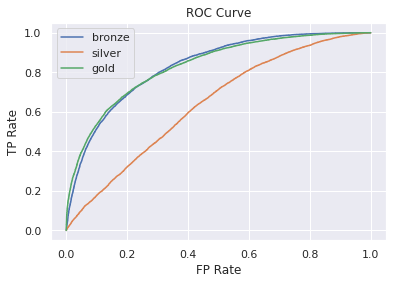

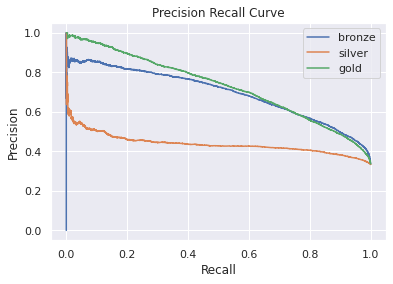

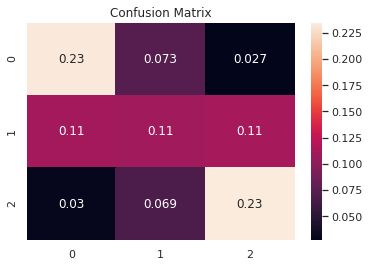

In [ ]:
# Resample based on SMOTE
train_feature_smote, train_label_smote, train_group_smote = get_smote_resample(train_card_features, train_card_labels, train_card_groups)

# Run initial tests, to see improvements. 
chungus2 = ModelValidator(train_feature_smote, train_label_smote, train_group_smote)
chungus2.do_machine_learning()

In [ ]:
train_group_smote.where(train_group_smote == 351187)

,0
0,351187.0
1,NaN
2,NaN
3,NaN
4,NaN
...,...
25072,NaN
25073,NaN
25074,NaN
25075,NaN


# SMOTE Over smple, then Undersample

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Dummy Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.33      0.33      0.33      5000
      silver       0.34      0.34      0.34      5000
        gold       0.34      0.34      0.34      5000

    accuracy                           0.34     15000
   macro avg       0.34      0.34      0.34     15000
weighted avg       0.34      0.34      0.34     15000

Balanced Accuracy: 0.337
ROC AUC Values: 0.4978


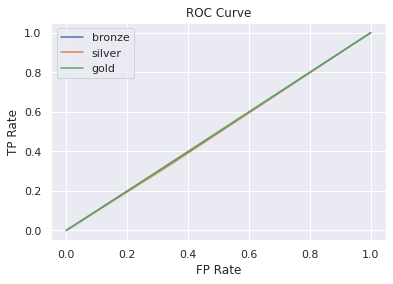

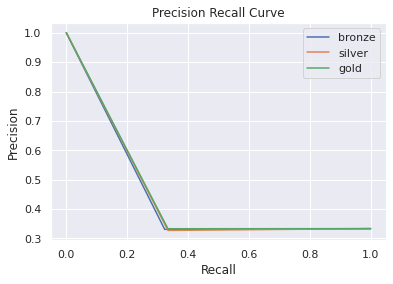

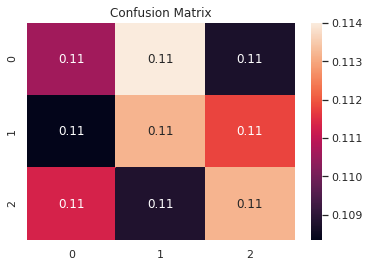

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

GaussianNB Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.75      0.85      0.80      5000
      silver       0.65      0.40      0.50      5000
        gold       0.68      0.84      0.75      5000

    accuracy                           0.70     15000
   macro avg       0.69      0.70      0.68     15000
weighted avg       0.69      0.70      0.68     15000

Balanced Accuracy: 0.6988
ROC AUC Values: 0.8702878399999999


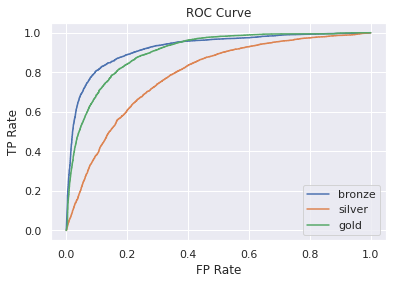

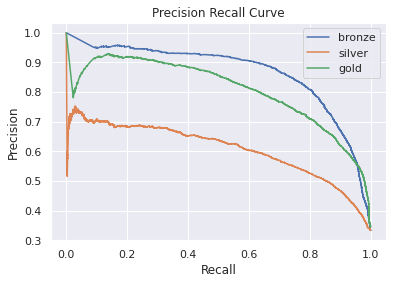

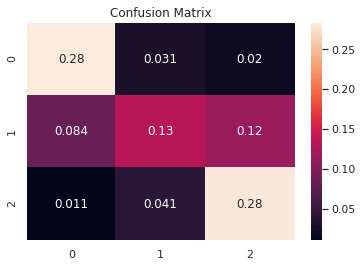

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

LogisticRegression Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.62      0.70      0.66      5000
      silver       0.44      0.32      0.37      5000
        gold       0.62      0.70      0.66      5000

    accuracy                           0.58     15000
   macro avg       0.56      0.58      0.56     15000
weighted avg       0.56      0.58      0.56     15000

Balanced Accuracy: 0.5771333333333334
ROC AUC Values: 0.7643697866666667


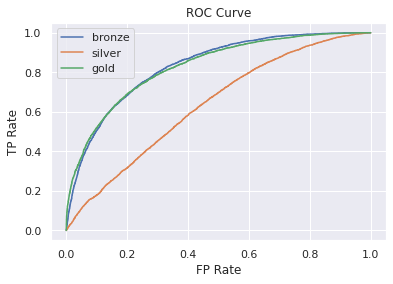

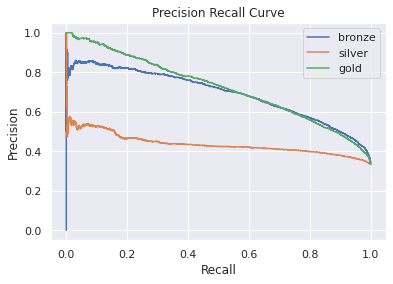

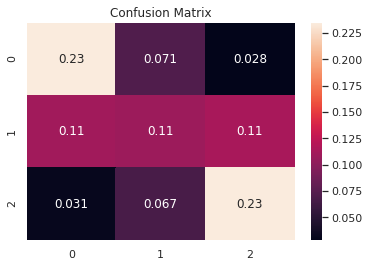

In [ ]:
# Implement undersampling SMOTE:
# Then, Resample based on SMOTE
train_feature_smote_u, train_label_smote_u, train_group_smote_u = get_undersample(pd.DataFrame(train_feature_smote), pd.DataFrame(train_label_smote), pd.DataFrame(train_group_smote), samp_strat={0:5000, 1:5000, 2:5000})

# Run initial tests, to see improvements. 
chungus3 = ModelValidator(train_feature_smote_u, train_label_smote_u, train_group_smote_u)
chungus3.do_machine_learning()

# Raw Undersample

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Dummy Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.34      0.34      0.34      1498
      silver       0.32      0.33      0.33      1498
        gold       0.34      0.32      0.33      1498

    accuracy                           0.33      4494
   macro avg       0.33      0.33      0.33      4494
weighted avg       0.33      0.33      0.33      4494

Balanced Accuracy: 0.3317757009345794
ROC AUC Values: 0.5018357810413885


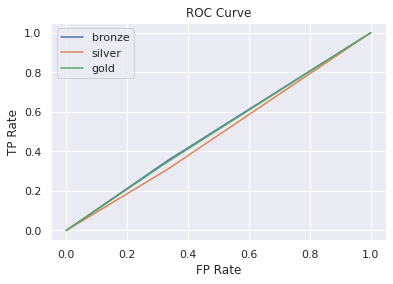

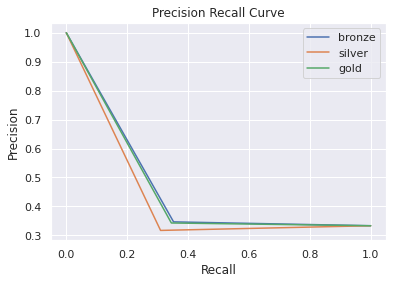

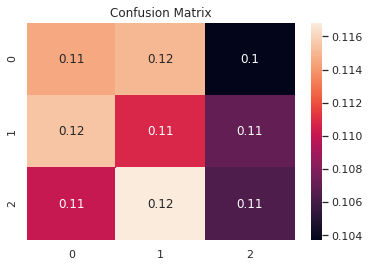

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

GaussianNB Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.75      0.74      0.75      1498
      silver       0.61      0.50      0.55      1498
        gold       0.69      0.82      0.75      1498

    accuracy                           0.69      4494
   macro avg       0.68      0.69      0.68      4494
weighted avg       0.68      0.69      0.68      4494

Balanced Accuracy: 0.6869158878504673
ROC AUC Values: 0.8469678158624792


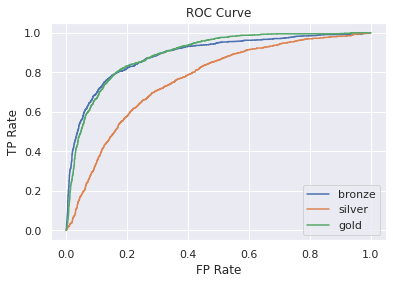

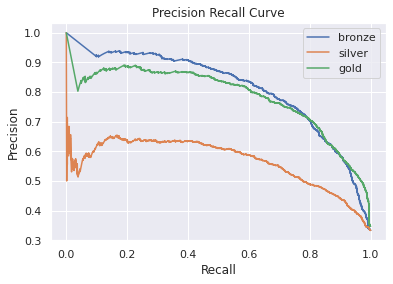

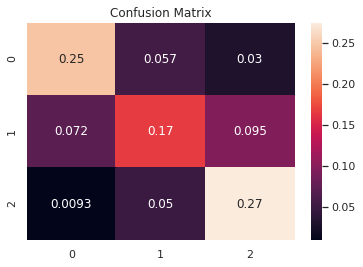

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

LogisticRegression Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.61      0.69      0.65      1498
      silver       0.43      0.33      0.37      1498
        gold       0.61      0.69      0.65      1498

    accuracy                           0.57      4494
   macro avg       0.55      0.57      0.56      4494
weighted avg       0.55      0.57      0.56      4494

Balanced Accuracy: 0.5683133066310636
ROC AUC Values: 0.7590288014935207


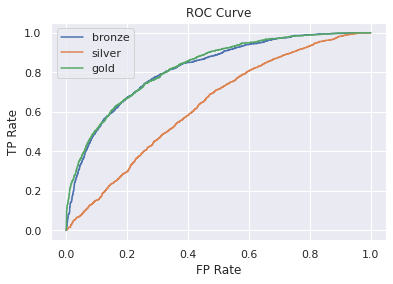

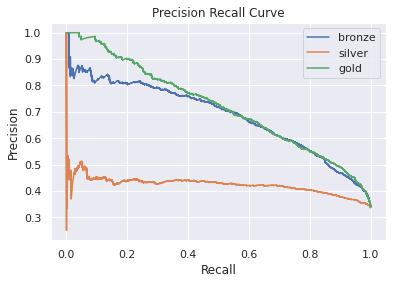

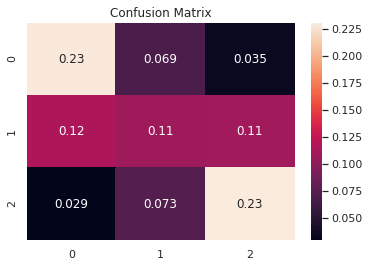

In [ ]:
# Implement undersampling NO SMOTE:
# Resample based on SMOTE
train_feature_under, train_label_under, train_group_under = get_undersample(train_card_features, train_card_labels, train_card_groups)

# Run initial tests, to see improvements. 
chungus4 = ModelValidator(train_feature_under, train_label_under, train_group_under)
chungus4.do_machine_learning()

# Raw Over Sampling


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Dummy Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.33      0.33      0.33      8359
      silver       0.33      0.32      0.33      8359
        gold       0.33      0.33      0.33      8359

    accuracy                           0.33     25077
   macro avg       0.33      0.33      0.33     25077
weighted avg       0.33      0.33      0.33     25077

Balanced Accuracy: 0.3300235275351916
ROC AUC Values: 0.49919248713961


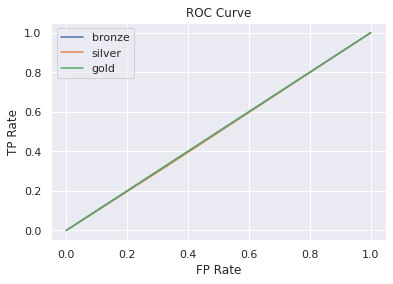

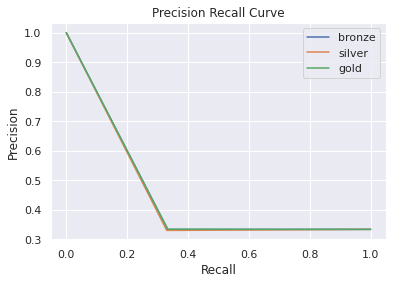

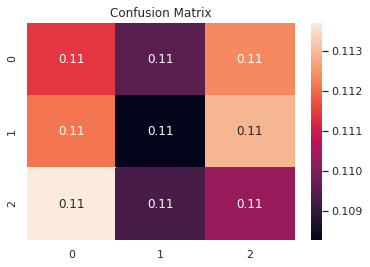

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

GaussianNB Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.73      0.78      0.75      8359
      silver       0.60      0.41      0.49      8359
        gold       0.66      0.83      0.73      8359

    accuracy                           0.67     25077
   macro avg       0.66      0.67      0.66     25077
weighted avg       0.66      0.67      0.66     25077

Balanced Accuracy: 0.6705746301391713
ROC AUC Values: 0.844296604381701


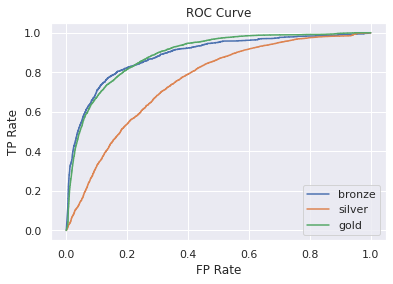

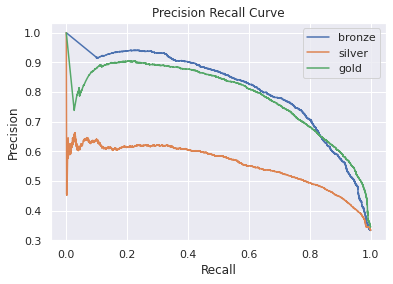

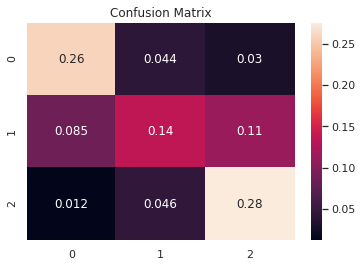

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

LogisticRegression Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.61      0.70      0.66      8359
      silver       0.45      0.32      0.37      8359
        gold       0.62      0.70      0.66      8359

    accuracy                           0.58     25077
   macro avg       0.56      0.58      0.56     25077
weighted avg       0.56      0.58      0.56     25077

Balanced Accuracy: 0.5758264545200782
ROC AUC Values: 0.7630865972164508


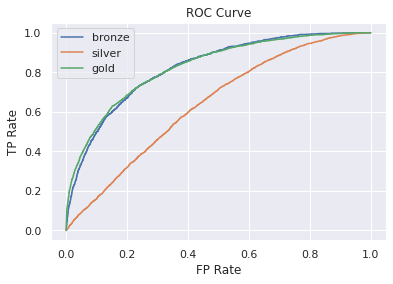

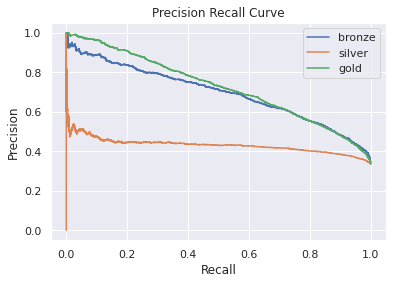

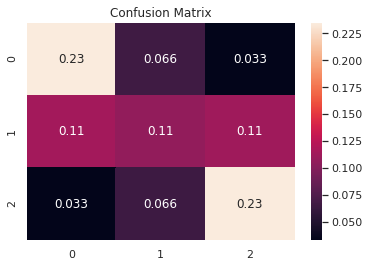

In [ ]:
# Oversample 
# Resample based on SMOTE
train_feature_over, train_label_over, train_group_over = get_oversample(train_card_features, train_card_labels, train_card_groups)

# Run initial tests, to see improvements. 
chungus4 = ModelValidator(train_feature_over, train_label_over, train_group_over)
chungus4.do_machine_learning()

# Oversample Even More with SMOTE

/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (15000) in class 0 will be larger than the number of samples in the majority class (class #1 -> 8359)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (15000) in class 1 will be larger than the number of samples in the majority class (class #1 -> 8359)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (15000) in class 2 will be larger than the number of samples in the majority class (class #1 -> 8359)
  n_samples_majority))
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category

Dummy Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.34      0.34      0.34     15000
      silver       0.34      0.33      0.33     15000
        gold       0.34      0.34      0.34     15000

    accuracy                           0.34     45000
   macro avg       0.34      0.34      0.34     45000
weighted avg       0.34      0.34      0.34     45000

Balanced Accuracy: 0.33664444444444447
ROC AUC Values: 0.5003166666666666


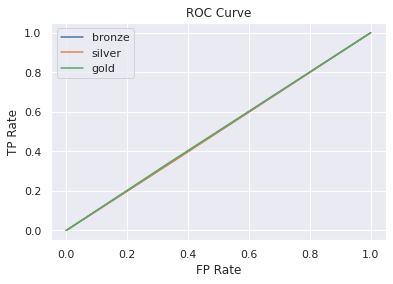

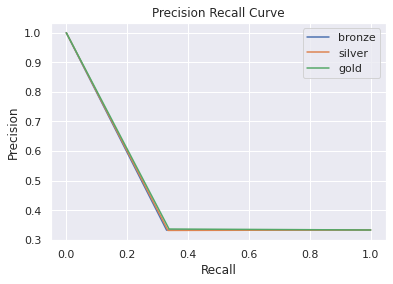

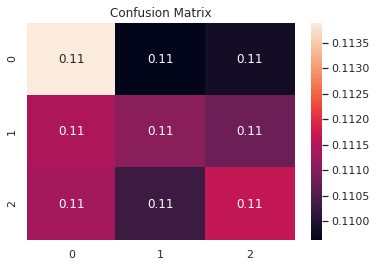

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

GaussianNB Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.75      0.84      0.79     15000
      silver       0.66      0.43      0.52     15000
        gold       0.70      0.85      0.77     15000

    accuracy                           0.71     45000
   macro avg       0.70      0.71      0.69     45000
weighted avg       0.70      0.71      0.69     45000

Balanced Accuracy: 0.7081555555555555
ROC AUC Values: 0.8731851714814816


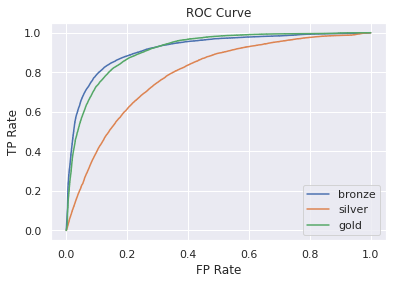

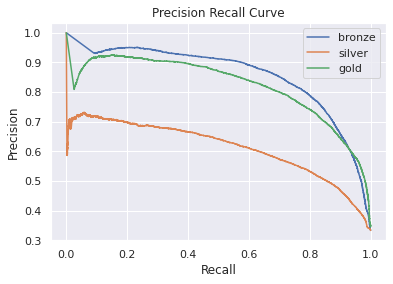

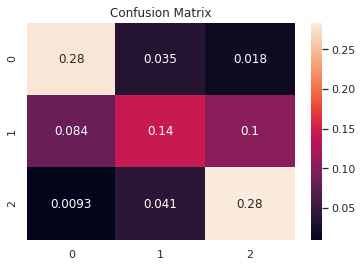

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example

LogisticRegression Model Report (Avg):
              precision    recall  f1-score   support

      bronze       0.63      0.70      0.66     15000
      silver       0.44      0.34      0.38     15000
        gold       0.63      0.71      0.67     15000

    accuracy                           0.58     45000
   macro avg       0.57      0.58      0.57     45000
weighted avg       0.57      0.58      0.57     45000

Balanced Accuracy: 0.5805777777777777
ROC AUC Values: 0.7704829762962964


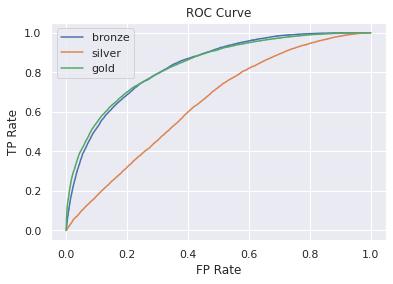

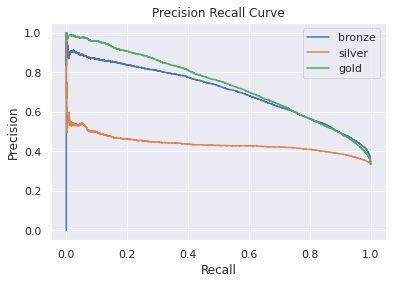

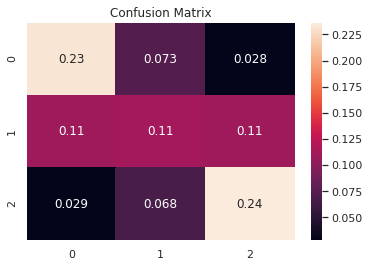

In [ ]:
# Resample based on SMOTE
train_feature_smote_over, train_label_smote_over, train_group_smote_over = get_smote_resample(train_card_features, train_card_labels, train_card_groups, samp_strat={0:15000,1:15000,2:15000})
# Run initial tests, to see improvements. 
chungus5 = ModelValidator(train_feature_smote_over, train_label_smote_over, train_group_smote_over)
chungus5.do_machine_learning()